In [28]:
import os
import librosa
import soundfile as sf
import pandas as pd

# Define input and output paths
input_folder = '/home/aayushjeevan/Desktop/FRONTERA/donateacry_corpus'
output_folder = '/home/aayushjeevan/Desktop/FRONTERA/cry_processed'
os.makedirs(output_folder, exist_ok=True)

# Sampling rate and bit depth
target_sr = 16000  # 16kHz sampling rate

# Prepare labels list
data = []

# Function to process audio files
def preprocess_audio(file_path, output_path, label='crying'):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=target_sr, mono=True)
    # Save the preprocessed audio
    sf.write(output_path, audio, target_sr)
    # Append file and label
    data.append({'file': output_path, 'label': label})

# Traverse folders and process files
for root, _, files in os.walk(input_folder):
    for file in files:
        if file.endswith('.wav'):
            input_file = os.path.join(root, file)
            output_file = os.path.join(output_folder, file)
            preprocess_audio(input_file, output_file)

# Save labels to CSV
labels_df = pd.DataFrame(data)
labels_df.to_csv(os.path.join(output_folder, 'labels.csv'), index=False)

print(f"Preprocessing complete! Files saved in {output_folder}")


Preprocessing complete! Files saved in /home/aayushjeevan/Desktop/FRONTERA/cry_processed


In [29]:
import os
import librosa
import soundfile as sf
import pandas as pd

# Define input and output paths
input_folder = '/home/aayushjeevan/Desktop/FRONTERA/archive3'
scream_output_folder = '/home/aayushjeevan/Desktop/FRONTERA/scream_processed'
normal_output_folder = '/home/aayushjeevan/Desktop/FRONTERA/normal_processed'
os.makedirs(scream_output_folder, exist_ok=True)
os.makedirs(normal_output_folder, exist_ok=True)

# Sampling rate and bit depth
target_sr = 16000  # 16kHz sampling rate

# Prepare labels list
data = []

# Function to process audio files
def preprocess_audio(file_path, output_path, label):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=target_sr, mono=True)
    # Save the preprocessed audio
    sf.write(output_path, audio, target_sr)
    # Append file and label
    data.append({'file': output_path, 'label': label})

# Traverse only Screaming and NotScreaming folders
screaming_folder = os.path.join(input_folder, 'Screaming')
notscreaming_folder = os.path.join(input_folder, 'NotScreaming')

for file in os.listdir(screaming_folder):
    if file.endswith('.wav'):
        input_file = os.path.join(screaming_folder, file)
        output_file = os.path.join(scream_output_folder, file)
        preprocess_audio(input_file, output_file, 'screaming')

for file in os.listdir(notscreaming_folder):
    if file.endswith('.wav'):
        input_file = os.path.join(notscreaming_folder, file)
        output_file = os.path.join(normal_output_folder, file)
        preprocess_audio(input_file, output_file, 'normal')

# Append labels to existing CSV
labels_csv_path = '/home/aayushjeevan/Desktop/FRONTERA/cry_processed/labels.csv'
if os.path.exists(labels_csv_path):
    existing_labels_df = pd.read_csv(labels_csv_path)
    labels_df = pd.DataFrame(data)
    combined_labels_df = pd.concat([existing_labels_df, labels_df], ignore_index=True)
    combined_labels_df.to_csv(labels_csv_path, index=False)
else:
    labels_df = pd.DataFrame(data)
    labels_df.to_csv(labels_csv_path, index=False)



In [30]:
import pandas as pd
import torchaudio
import librosa
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Load labels.csv
labels_csv_path = '/home/aayushjeevan/Desktop/FRONTERA/cry_processed/labels.csv'
df = pd.read_csv(labels_csv_path)

# Ensure labels are consistent
label_mapping = {'crying': 0, 'screaming': 1, 'normal': 2}
df['label'] = df['label'].map(label_mapping)

# Split into train/val/test (70/15/15)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Convert to Hugging Face Dataset
def load_audio_data(example):
    file_path = os.path.join('/home/aayushjeevan/Desktop/FRONTERA/', example['file'])
    audio, sr = librosa.load(file_path, sr=16000)
    example['array'] = audio
    example['sampling_rate'] = sr
    return example

train_ds = Dataset.from_pandas(train_df).map(load_audio_data)
val_ds = Dataset.from_pandas(val_df).map(load_audio_data)
test_ds = Dataset.from_pandas(test_df).map(load_audio_data)

print(train_ds, val_ds, test_ds)


Map:   0%|          | 0/2765 [00:00<?, ? examples/s]

Map:   0%|          | 0/592 [00:00<?, ? examples/s]

Map:   0%|          | 0/593 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'label', '__index_level_0__', 'array', 'sampling_rate'],
    num_rows: 2765
}) Dataset({
    features: ['file', 'label', '__index_level_0__', 'array', 'sampling_rate'],
    num_rows: 592
}) Dataset({
    features: ['file', 'label', '__index_level_0__', 'array', 'sampling_rate'],
    num_rows: 593
})


In [31]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base")

def preprocess_function(examples):
    inputs = processor(examples["array"], sampling_rate=16000, padding=True, return_tensors="pt")
    return inputs

train_ds = train_ds.map(preprocess_function, remove_columns=["file", "array", "sampling_rate"])
val_ds = val_ds.map(preprocess_function, remove_columns=["file", "array", "sampling_rate"])
test_ds = test_ds.map(preprocess_function, remove_columns=["file", "array", "sampling_rate"])


/home/aayushjeevan/anaconda3/lib/python3.12/site-packages/transformers/configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/2765 [00:00<?, ? examples/s]

Map:   0%|          | 0/592 [00:00<?, ? examples/s]

Map:   0%|          | 0/593 [00:00<?, ? examples/s]

In [32]:
from transformers import AutoModelForAudioClassification

model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=3,
    label2id={label: i for i, label in enumerate(['crying', 'screaming', 'normal'])},
    id2label={i: label for i, label in enumerate(['crying', 'screaming', 'normal'])}
)

model.config.classifier_dropout = 0.3  # Reduce overfitting


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
from transformers import TrainingArguments, Trainer
import torch
import evaluate
import numpy as np

# Metric for evaluation
metric = evaluate.load("accuracy")

# Function to compute evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = torch.argmax(torch.tensor(predictions), dim=1)
    return metric.compute(predictions=predictions, references=labels)

# Custom data collator for Wav2Vec2
class DataCollatorForWav2Vec2:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, features):
        # Extract raw audio and labels
        input_values = [feature["input_values"] for feature in features]
        labels = [feature["label"] for feature in features]

        # Ensure input_values are in the correct format (list of lists)
        input_values = [np.array(iv).flatten().tolist() for iv in input_values]

        # Pad input_values
        batch = self.processor(
            input_values,
            sampling_rate=16000,
            padding=True,  # Ensures dynamic padding
            truncation=True,
            max_length=16000 * 5,  # 5 seconds max
            return_tensors="pt"
        )

        # Convert labels to tensor
        batch["labels"] = torch.tensor(labels, dtype=torch.long)

        return batch

# Initialize collator
data_collator = DataCollatorForWav2Vec2(processor)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"  # set to "wandb" or "tensorboard" if needed
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

# Save the fine-tuned model and processor
model.save_pretrained("./fine_tuned_wav2vec2")
processor.save_pretrained("./fine_tuned_wav2vec2")

print("Model and processor saved to './fine_tuned_wav2vec2'")

# ---- TESTING ----
# Predict on test set
test_results = trainer.predict(test_ds)

# Get predictions and labels
predictions = torch.argmax(torch.tensor(test_results.predictions), dim=1)
labels = torch.tensor(test_results.label_ids)

# Calculate test accuracy
test_accuracy = metric.compute(predictions=predictions, references=labels)['accuracy']
print(f"Test Accuracy: {test_accuracy:.2%}")


/home/aayushjeevan/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_954358/2282971703.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


  0%|          | 0/3460 [00:00<?, ?it/s]

{'loss': 0.9919, 'grad_norm': 3.0176048278808594, 'learning_rate': 1.994219653179191e-05, 'epoch': 0.03}
{'loss': 0.877, 'grad_norm': 2.9312586784362793, 'learning_rate': 1.9884393063583815e-05, 'epoch': 0.06}
{'loss': 0.7791, 'grad_norm': 1.384385585784912, 'learning_rate': 1.9826589595375726e-05, 'epoch': 0.09}
{'loss': 0.6978, 'grad_norm': 15.380253791809082, 'learning_rate': 1.9768786127167633e-05, 'epoch': 0.12}
{'loss': 0.8016, 'grad_norm': 5.750753879547119, 'learning_rate': 1.971098265895954e-05, 'epoch': 0.14}
{'loss': 0.686, 'grad_norm': 2.543133497238159, 'learning_rate': 1.9653179190751446e-05, 'epoch': 0.17}
{'loss': 0.7201, 'grad_norm': 3.1257357597351074, 'learning_rate': 1.9595375722543353e-05, 'epoch': 0.2}
{'loss': 0.5786, 'grad_norm': 6.135426998138428, 'learning_rate': 1.9537572254335264e-05, 'epoch': 0.23}
{'loss': 0.5225, 'grad_norm': 3.946971893310547, 'learning_rate': 1.947976878612717e-05, 'epoch': 0.26}
{'loss': 0.6454, 'grad_norm': 6.053271770477295, 'learnin

  0%|          | 0/74 [00:00<?, ?it/s]

{'eval_loss': 0.43279391527175903, 'eval_accuracy': 0.8378378378378378, 'eval_runtime': 33.7751, 'eval_samples_per_second': 17.528, 'eval_steps_per_second': 2.191, 'epoch': 1.0}
{'loss': 0.4068, 'grad_norm': 10.021428108215332, 'learning_rate': 1.7976878612716763e-05, 'epoch': 1.01}
{'loss': 0.381, 'grad_norm': 1.472680687904358, 'learning_rate': 1.7919075144508673e-05, 'epoch': 1.04}
{'loss': 0.3364, 'grad_norm': 58.81550216674805, 'learning_rate': 1.786127167630058e-05, 'epoch': 1.07}
{'loss': 0.4112, 'grad_norm': 50.63368606567383, 'learning_rate': 1.7803468208092487e-05, 'epoch': 1.1}
{'loss': 0.3415, 'grad_norm': 64.52495574951172, 'learning_rate': 1.7745664739884394e-05, 'epoch': 1.13}
{'loss': 0.3994, 'grad_norm': 12.079900741577148, 'learning_rate': 1.76878612716763e-05, 'epoch': 1.16}
{'loss': 0.439, 'grad_norm': 6.2717084884643555, 'learning_rate': 1.763005780346821e-05, 'epoch': 1.18}
{'loss': 0.3599, 'grad_norm': 8.916625022888184, 'learning_rate': 1.7572254335260118e-05, '

  0%|          | 0/74 [00:00<?, ?it/s]

{'eval_loss': 0.416307270526886, 'eval_accuracy': 0.8631756756756757, 'eval_runtime': 33.8143, 'eval_samples_per_second': 17.507, 'eval_steps_per_second': 2.188, 'epoch': 2.0}
{'loss': 0.2572, 'grad_norm': 6.779147624969482, 'learning_rate': 1.5953757225433528e-05, 'epoch': 2.02}
{'loss': 0.2246, 'grad_norm': 10.827028274536133, 'learning_rate': 1.5895953757225435e-05, 'epoch': 2.05}
{'loss': 0.326, 'grad_norm': 13.420013427734375, 'learning_rate': 1.5838150289017342e-05, 'epoch': 2.08}
{'loss': 0.2659, 'grad_norm': 0.6477757692337036, 'learning_rate': 1.578034682080925e-05, 'epoch': 2.11}
{'loss': 0.2768, 'grad_norm': 1.9430357217788696, 'learning_rate': 1.572254335260116e-05, 'epoch': 2.14}
{'loss': 0.4491, 'grad_norm': 1.6893500089645386, 'learning_rate': 1.5664739884393066e-05, 'epoch': 2.17}
{'loss': 0.7357, 'grad_norm': 22.797130584716797, 'learning_rate': 1.5606936416184973e-05, 'epoch': 2.2}
{'loss': 0.386, 'grad_norm': 17.674335479736328, 'learning_rate': 1.554913294797688e-05

  0%|          | 0/74 [00:00<?, ?it/s]

{'eval_loss': 0.38455814123153687, 'eval_accuracy': 0.8885135135135135, 'eval_runtime': 34.0003, 'eval_samples_per_second': 17.412, 'eval_steps_per_second': 2.176, 'epoch': 3.0}
{'loss': 0.2915, 'grad_norm': 9.45718002319336, 'learning_rate': 1.3988439306358383e-05, 'epoch': 3.01}
{'loss': 0.2682, 'grad_norm': 0.6702945828437805, 'learning_rate': 1.393063583815029e-05, 'epoch': 3.03}
{'loss': 0.3023, 'grad_norm': 0.5241795778274536, 'learning_rate': 1.3872832369942197e-05, 'epoch': 3.06}
{'loss': 0.2273, 'grad_norm': 8.70785140991211, 'learning_rate': 1.3815028901734104e-05, 'epoch': 3.09}
{'loss': 0.3239, 'grad_norm': 35.06383514404297, 'learning_rate': 1.3757225433526014e-05, 'epoch': 3.12}
{'loss': 0.4753, 'grad_norm': 26.636075973510742, 'learning_rate': 1.369942196531792e-05, 'epoch': 3.15}
{'loss': 0.1652, 'grad_norm': 2.1369788646698, 'learning_rate': 1.3641618497109828e-05, 'epoch': 3.18}
{'loss': 0.182, 'grad_norm': 42.24102783203125, 'learning_rate': 1.3583815028901735e-05, '

  0%|          | 0/74 [00:00<?, ?it/s]

{'eval_loss': 0.46397194266319275, 'eval_accuracy': 0.8766891891891891, 'eval_runtime': 34.0817, 'eval_samples_per_second': 17.37, 'eval_steps_per_second': 2.171, 'epoch': 4.0}
{'loss': 0.2381, 'grad_norm': 3.425333261489868, 'learning_rate': 1.1965317919075146e-05, 'epoch': 4.02}
{'loss': 0.2653, 'grad_norm': 0.3114086985588074, 'learning_rate': 1.1907514450867053e-05, 'epoch': 4.05}
{'loss': 0.2348, 'grad_norm': 35.966346740722656, 'learning_rate': 1.184971098265896e-05, 'epoch': 4.08}
{'loss': 0.1838, 'grad_norm': 60.22093963623047, 'learning_rate': 1.1791907514450869e-05, 'epoch': 4.1}
{'loss': 0.2785, 'grad_norm': 2.508216142654419, 'learning_rate': 1.1734104046242775e-05, 'epoch': 4.13}
{'loss': 0.2036, 'grad_norm': 2.0821943283081055, 'learning_rate': 1.1676300578034682e-05, 'epoch': 4.16}
{'loss': 0.314, 'grad_norm': 1.5883985757827759, 'learning_rate': 1.161849710982659e-05, 'epoch': 4.19}
{'loss': 0.2987, 'grad_norm': 0.8127607107162476, 'learning_rate': 1.15606936416185e-05,

  0%|          | 0/74 [00:00<?, ?it/s]

{'eval_loss': 0.4935361444950104, 'eval_accuracy': 0.8733108108108109, 'eval_runtime': 34.0724, 'eval_samples_per_second': 17.375, 'eval_steps_per_second': 2.172, 'epoch': 5.0}
{'loss': 0.1658, 'grad_norm': 0.3279617428779602, 'learning_rate': 9.942196531791908e-06, 'epoch': 5.03}
{'loss': 0.1509, 'grad_norm': 12.510065078735352, 'learning_rate': 9.884393063583816e-06, 'epoch': 5.06}
{'loss': 0.3034, 'grad_norm': 16.9424991607666, 'learning_rate': 9.826589595375723e-06, 'epoch': 5.09}
{'loss': 0.241, 'grad_norm': 13.197035789489746, 'learning_rate': 9.768786127167632e-06, 'epoch': 5.12}
{'loss': 0.1236, 'grad_norm': 0.32131344079971313, 'learning_rate': 9.710982658959539e-06, 'epoch': 5.14}
{'loss': 0.2148, 'grad_norm': 17.904037475585938, 'learning_rate': 9.653179190751446e-06, 'epoch': 5.17}
{'loss': 0.2319, 'grad_norm': 0.27298834919929504, 'learning_rate': 9.595375722543352e-06, 'epoch': 5.2}
{'loss': 0.1573, 'grad_norm': 0.28014808893203735, 'learning_rate': 9.537572254335261e-06,

  0%|          | 0/74 [00:00<?, ?it/s]

{'eval_loss': 0.5244150161743164, 'eval_accuracy': 0.8665540540540541, 'eval_runtime': 33.9667, 'eval_samples_per_second': 17.429, 'eval_steps_per_second': 2.179, 'epoch': 6.0}
{'loss': 0.1946, 'grad_norm': 0.6772587895393372, 'learning_rate': 7.976878612716764e-06, 'epoch': 6.01}
{'loss': 0.0592, 'grad_norm': 0.6252508163452148, 'learning_rate': 7.919075144508671e-06, 'epoch': 6.04}
{'loss': 0.2059, 'grad_norm': 3.0221314430236816, 'learning_rate': 7.86127167630058e-06, 'epoch': 6.07}
{'loss': 0.0635, 'grad_norm': 0.19497694075107574, 'learning_rate': 7.803468208092486e-06, 'epoch': 6.1}
{'loss': 0.243, 'grad_norm': 0.23054230213165283, 'learning_rate': 7.745664739884393e-06, 'epoch': 6.13}
{'loss': 0.2349, 'grad_norm': 0.2922471761703491, 'learning_rate': 7.687861271676302e-06, 'epoch': 6.16}
{'loss': 0.1008, 'grad_norm': 0.6165456175804138, 'learning_rate': 7.630057803468209e-06, 'epoch': 6.18}
{'loss': 0.0935, 'grad_norm': 27.992610931396484, 'learning_rate': 7.5722543352601166e-06

  0%|          | 0/74 [00:00<?, ?it/s]

{'eval_loss': 0.5829776525497437, 'eval_accuracy': 0.8665540540540541, 'eval_runtime': 34.3229, 'eval_samples_per_second': 17.248, 'eval_steps_per_second': 2.156, 'epoch': 7.0}
{'loss': 0.3352, 'grad_norm': 6.5905327796936035, 'learning_rate': 5.9537572254335265e-06, 'epoch': 7.02}
{'loss': 0.1434, 'grad_norm': 0.19199329614639282, 'learning_rate': 5.895953757225434e-06, 'epoch': 7.05}
{'loss': 0.0679, 'grad_norm': 0.6215019822120667, 'learning_rate': 5.838150289017341e-06, 'epoch': 7.08}
{'loss': 0.0648, 'grad_norm': 0.14847657084465027, 'learning_rate': 5.78034682080925e-06, 'epoch': 7.11}
{'loss': 0.1379, 'grad_norm': 0.15492530167102814, 'learning_rate': 5.722543352601157e-06, 'epoch': 7.14}
{'loss': 0.1667, 'grad_norm': 0.10055476427078247, 'learning_rate': 5.664739884393064e-06, 'epoch': 7.17}
{'loss': 0.1039, 'grad_norm': 0.1959397941827774, 'learning_rate': 5.606936416184971e-06, 'epoch': 7.2}
{'loss': 0.1978, 'grad_norm': 0.15305273234844208, 'learning_rate': 5.549132947976878

  0%|          | 0/74 [00:00<?, ?it/s]

{'eval_loss': 0.6193937063217163, 'eval_accuracy': 0.8699324324324325, 'eval_runtime': 34.2, 'eval_samples_per_second': 17.31, 'eval_steps_per_second': 2.164, 'epoch': 8.0}
{'loss': 0.068, 'grad_norm': 0.0943848192691803, 'learning_rate': 3.988439306358382e-06, 'epoch': 8.01}
{'loss': 0.14, 'grad_norm': 0.11470434814691544, 'learning_rate': 3.93063583815029e-06, 'epoch': 8.03}
{'loss': 0.1801, 'grad_norm': 93.41809844970703, 'learning_rate': 3.872832369942197e-06, 'epoch': 8.06}
{'loss': 0.036, 'grad_norm': 0.12954479455947876, 'learning_rate': 3.815028901734104e-06, 'epoch': 8.09}
{'loss': 0.0372, 'grad_norm': 0.08178813755512238, 'learning_rate': 3.7572254335260117e-06, 'epoch': 8.12}
{'loss': 0.1748, 'grad_norm': 2.99605131149292, 'learning_rate': 3.699421965317919e-06, 'epoch': 8.15}
{'loss': 0.1928, 'grad_norm': 0.25401368737220764, 'learning_rate': 3.641618497109827e-06, 'epoch': 8.18}
{'loss': 0.1368, 'grad_norm': 2.1179773807525635, 'learning_rate': 3.583815028901734e-06, 'epoc

  0%|          | 0/74 [00:00<?, ?it/s]

{'eval_loss': 0.6582999229431152, 'eval_accuracy': 0.8648648648648649, 'eval_runtime': 34.2446, 'eval_samples_per_second': 17.287, 'eval_steps_per_second': 2.161, 'epoch': 9.0}
{'loss': 0.1537, 'grad_norm': 39.213775634765625, 'learning_rate': 1.965317919075145e-06, 'epoch': 9.02}
{'loss': 0.0721, 'grad_norm': 0.11243782192468643, 'learning_rate': 1.907514450867052e-06, 'epoch': 9.05}
{'loss': 0.008, 'grad_norm': 0.10910601913928986, 'learning_rate': 1.8497109826589595e-06, 'epoch': 9.08}
{'loss': 0.1324, 'grad_norm': 0.18856866657733917, 'learning_rate': 1.791907514450867e-06, 'epoch': 9.1}
{'loss': 0.0715, 'grad_norm': 0.15669940412044525, 'learning_rate': 1.7341040462427746e-06, 'epoch': 9.13}
{'loss': 0.0067, 'grad_norm': 0.13039954006671906, 'learning_rate': 1.6763005780346821e-06, 'epoch': 9.16}
{'loss': 0.073, 'grad_norm': 0.14076802134513855, 'learning_rate': 1.6184971098265898e-06, 'epoch': 9.19}
{'loss': 0.2075, 'grad_norm': 0.11583279073238373, 'learning_rate': 1.56069364161

  0%|          | 0/74 [00:00<?, ?it/s]

{'eval_loss': 0.6659386157989502, 'eval_accuracy': 0.8648648648648649, 'eval_runtime': 34.4506, 'eval_samples_per_second': 17.184, 'eval_steps_per_second': 2.148, 'epoch': 10.0}
{'train_runtime': 4215.4937, 'train_samples_per_second': 6.559, 'train_steps_per_second': 0.821, 'train_loss': 0.2585681182057785, 'epoch': 10.0}
Model and processor saved to './fine_tuned_wav2vec2'


  0%|          | 0/75 [00:00<?, ?it/s]

Test Accuracy: 85.67%


  0%|          | 0/75 [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

      crying       0.97      0.91      0.94        68
   screaming       0.73      0.63      0.67       130
      normal       0.88      0.92      0.90       395

    accuracy                           0.86       593
   macro avg       0.86      0.82      0.84       593
weighted avg       0.85      0.86      0.85       593



<Figure size 800x600 with 0 Axes>

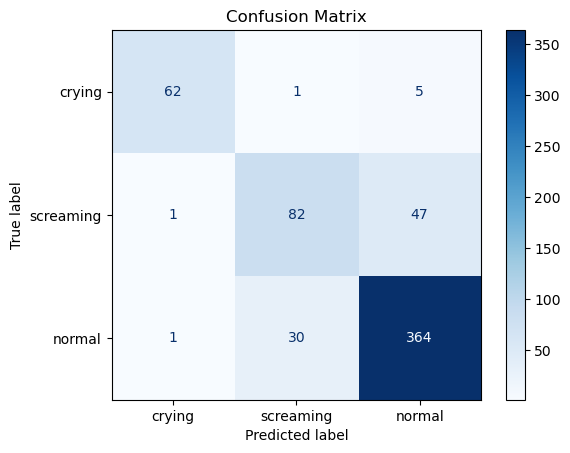

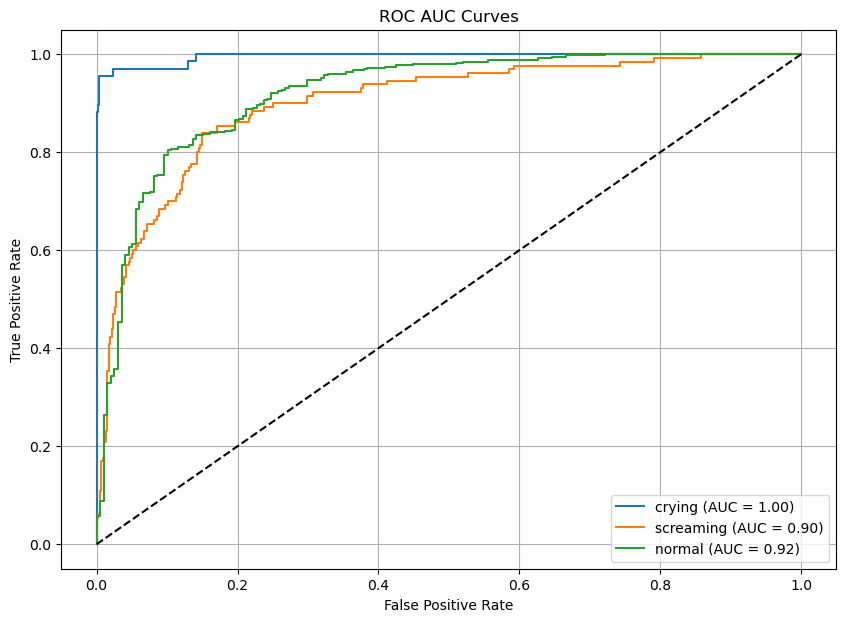

Overall ROC AUC Score: 0.94


In [35]:
from sklearn.metrics import (classification_report, roc_auc_score, roc_curve, 
                             auc, confusion_matrix, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import torch
import numpy as np

# Predict on test set
predictions = trainer.predict(test_ds)
pred_probs = torch.tensor(predictions.predictions)
preds = torch.argmax(pred_probs, dim=1)

# Ensure labels are numpy arrays
labels = np.array(test_ds['label'])
pred_probs = pred_probs.detach().cpu().numpy()

# Classification report
print("Classification Report:")
print(classification_report(labels, preds.numpy(), target_names=['crying', 'screaming', 'normal']))

# Compute confusion matrix
conf_matrix = confusion_matrix(labels, preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['crying', 'screaming', 'normal'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC Curve
plt.figure(figsize=(10, 7))
for i, label in enumerate(['crying', 'screaming', 'normal']):
    binary_labels = (labels == i).astype(int)
    fpr, tpr, _ = roc_curve(binary_labels, pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Calculate overall ROC AUC score (one-vs-rest)
overall_roc_auc = roc_auc_score(np.eye(len(set(labels)))[labels], pred_probs, multi_class='ovr')
print(f"Overall ROC AUC Score: {overall_roc_auc:.2f}")



In [43]:
import librosa
import torch
from transformers import AutoProcessor, AutoModelForAudioClassification
import numpy as np
import torch.nn.functional as F  # For softmax

# Load the fine-tuned model and processor
model = AutoModelForAudioClassification.from_pretrained("./fine_tuned_wav2vec2")
processor = AutoProcessor.from_pretrained("./fine_tuned_wav2vec2")

# Mapping for labels
label_mapping = {0: 'crying', 1: 'screaming', 2: 'normal'}

# Function to predict the label of a single audio file
def predict_audio_label(audio_path):
    # Load audio file using librosa
    audio, sr = librosa.load(audio_path, sr=16000)

    # Preprocess the audio file (removed truncation argument)
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
    
    # Perform the prediction
    with torch.no_grad():
        logits = model(**inputs).logits

    # Convert logits to probabilities using softmax
    probs = F.softmax(logits, dim=-1)

    # Get the predicted label
    predicted_class_id = torch.argmax(logits, dim=-1).item()
    predicted_label = label_mapping[predicted_class_id]
    
    # Print the probabilities for all classes
    for i, label in label_mapping.items():
        print(f"Probability of {label}: {probs[0][i].item():.4f}")
    
    return predicted_label

# Test with a single audio file
audio_path = "/home/aayushjeevan/Desktop/FRONTERA/archive3/Screaming/0kQANiakiH0_out.wav"
predicted_label = predict_audio_label(audio_path)

print(f"The predicted label for the audio file is: {predicted_label}")


Probability of crying: 0.0147
Probability of screaming: 0.9602
Probability of normal: 0.0251
The predicted label for the audio file is: screaming
